**Tensorflow MNIST Handwritten digits low-level**

Maintenant qu'on a pu voir les opérations de base de Tensorflow, on va pouvoir passer à notre premier modèle de machine learning sur Tensorflow.
Le principe sera de ré-implémenter la régression logistique comme vous l'avez fait au workshop précédent, mais pour un problème de classification multi-classes cette fois.

Le but de ce modèle sera d'identifier le chiffre correct écrit manuellement sur une image. Pour cela, nous allons utiliser le dataset **MNIST handwritten digits**.


Ce dataset contient 60000 exemples de train et 10000 de test. Les images ont déjà été normalisées et centrées dans une image de taille fixe (28*28 pixels) avec des valeurs allant de 0 à 255.
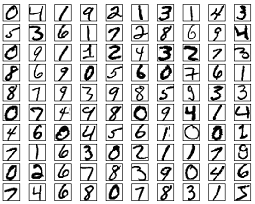

Pour plus d'informations: http://yann.lecun.com/exdb/mnist/

In [1]:
import tensorflow as tf
import numpy as np

Commençons par définir les variables qui nous seront utiles.

In [2]:
# Paramètres du dataset MNIST
num_classes = 10 # 10 chiffres
num_features = 784 # 28*28

# Paramètres de l'entraînement
learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

In [3]:
# On load le dataset...
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# ... et on passe au préprocessing

On souhaite donner en entrée de notre modèle un vecteur de 784 entrées correspondant aux valeurs des pixels d'une image. Après avoir "flatten" nos jeux de données, normalisez les de façon à ce que leurs valeurs se situent entre 0 et 1. N'oubliez pas de convertir vos jeux de données en type float.


In [4]:
# Convertissez x_train et x_test en float
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Mettez vos jeux de données à plat. Indice: reshape 
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalisez les valeurs de vos images de [0, 255] à [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

On utilise l'API tf.data pour shuffle et batcher les données. Si vous ne savez pas ce que c'est, demandez à Google.
Ce qui est important en machine learning, ce n'est pas de savoir comment le faire, mais **pourquoi**. A partir du moment où vous voudriez faire quelque chose et que vous ne savez pas le faire, une simple recherche Google vous donnera la solution. Ceci ne marche que si vous savez ce que vous voulez faire. Focalisez vous alors davantage sur le pourquoi.

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

On continue en initialisant W et b.

In [6]:
# Matrice de shape [784, 10] qui correspond aux 28*28 features et entrées et aux 10 classes en sortie.
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# Vecteur de shape [10], nombre de classes.
b = tf.Variable(tf.zeros([num_classes]), name="bias")

**Exercice**: Définissez la fonction logistic_regression. Utilisez la fonction softmax pour normaliser les logits en une distribution de probabilités. 

**Indice**: Commencez par calculer les logits, puis https://www.tensorflow.org/api_docs/python/tf/nn/softmax 

In [7]:
def logistic_regression(x):
    ### Début du code ###
    logits = tf.matmul(x, W) + b
    softmax = tf.nn.softmax(logits)
    ### Fin du code ###
    return softmax

**Exercice:** Implémentez la fonction de loss cross_entropy

**Incide**: Retrouvez la bonne formule dans ce lien https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html. Pour rappel, notre problème est une classification multi-classes.

In [8]:
def cross_entropy(y_pred, y_true):
    # On encode d'abord les labels en vecteur one hot.
    y_true = tf.one_hot(y_true, depth=num_classes)
    
    # On clip les valeurs de prédiction pour éviter les erreurs de log(0). N'hésitez pas à voir la doc pour comprendre les paramètres des différentes fonctions.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    
    # Calcul de la cross entropy
    ### Début du code ###
    cross_ent = -tf.reduce_sum(y_true * tf.math.log(y_pred))
    mean = tf.reduce_mean(cross_ent)
    ### Fin du code ###
    return mean

On définit la fonction accurary qui nous permettra de vérifier la pertinence de notre modèle.

In [9]:
def accuracy(y_pred, y_true):
    # La classe prédite est celle qui a le plus score dans le vecteur de prédiction (argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Définissons notre optimizer. On utilisera la descente de gradient stochastique.

In [10]:
optimizer = tf.optimizers.SGD(learning_rate)

Utilisons les fonctions définies précedemment pour définir la fonction run_optimization. Si vous avez correctement fait votre travail plus haut et vous êtes renseignés sur l'utilité des batch, sachez que la fonction run_optimization prend en paramètres des batch.
Il vous est utile de vous renseigner sur https://www.tensorflow.org/tutorials/customization/autodiff et de manière générale la différenciation automatique pour comprendre la partie de code ci-dessous.

In [11]:
# La différenciation automatique optimise le calcul
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)

    # Calcul des gradients
    gradients = g.gradient(loss, [W, b])
    
    # Update W et b en fonction des gradients
    optimizer.apply_gradients(zip(gradients, [W, b]))

A présent, on va enfin pouvoir lancer l'entraînement. 

In [12]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step: 50, loss: 759.931396, accuracy: 0.675781
step: 100, loss: 82.609154, accuracy: 0.906250
step: 150, loss: 122.685127, accuracy: 0.890625
step: 200, loss: 67.754044, accuracy: 0.921875
step: 250, loss: 70.525269, accuracy: 0.910156
step: 300, loss: 90.835091, accuracy: 0.906250
step: 350, loss: 60.145477, accuracy: 0.925781
step: 400, loss: 96.146286, accuracy: 0.914062
step: 450, loss: 39.843567, accuracy: 0.964844
step: 500, loss: 89.910370, accuracy: 0.914062
step: 550, loss: 67.282570, accuracy: 0.925781
step: 600, loss: 83.312958, accuracy: 0.933594
step: 650, loss: 181.320511, accuracy: 0.851562
step: 700, loss: 62.675018, accuracy: 0.925781
step: 750, loss: 85.755127, accuracy: 0.906250
step: 800, loss: 74.353767, accuracy: 0.929688
step: 850, loss: 91.557983, accuracy: 0.921875
step: 900, loss: 80.444733, accuracy: 0.910156
step: 950, loss: 59.709591, accuracy: 0.933594
step: 1000,

On est en moyenne à 90% d'accuracy, plutôt pas mal ! Cela veut dire que sur 10 images, notre modèle parvient à identifier correctement 9 d'entres elles. Mais cet accuracy n'est valable que sur le dataset de train. Qu'en est-il sur le dataset de test ? Et surtout, pourquoi vérifier l'accuracy du dataset set ? 

**Réponse**: ... (appelez-nous si vous avez la réponse ;))

In [13]:
# Testons notre modèle sur le dataset de test
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.865900


Résultat semblable ! Notre modèle fonctionne plutôt bien. Le code ci-dessous vous permet de visualiser les prédictions de notre modèle. N'hésitez pas à modifier test_images pour visualiser d'autres images

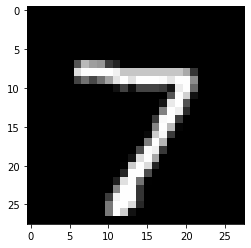

Model prediction: 7


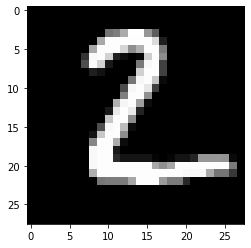

Model prediction: 2


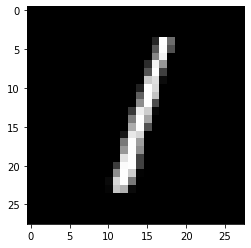

Model prediction: 1


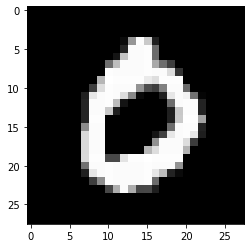

Model prediction: 0


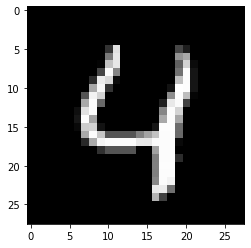

Model prediction: 4


In [15]:
# Visualisation des prédictions
import matplotlib.pyplot as plt
%matplotlib inline

# Prédiction de 5 images depuis le dataset de test.
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

# Affichage de l'image + la prédiction du modèle
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

**Félicitations !** Vous avez réalisé votre premier modèle de machine learning avec tensorflow. Ce modèle est considéré comme bas-niveau car vous avez dû ré-implémenter from scratch quelques fonctions comme la logistic_regression ou cross_entropy par exemple. Mais rassurez-vous, vous n'aurez pas à le faire à chaque fois car Tensorflow possède une API plus haut niveau qui facilitera grandement votre vie. On vous le répète, l'important en machine learning n'est pas de savoir comment implémenter telle ou telle fonction car il existe aujourd'hui de nombreuses librairies vous permettant de le faire, mais plutôt à quel moment utiliser quel fonction. Il n'y a pas de modèle général pour résoudre un problème, chaque solution dépend du jeu de données qui vous sera fourni et vous demande un gros travail de pré-processing. A la prochaine !